
# Associate Ca2+ signal with sleep stages

Load packages

In [166]:
cd "C:/Users/Manip2/SCRIPTS/Code python audrey/code python aurelie/interfaceJupyter/minian"

C:\Users\Manip2\SCRIPTS\Code python audrey\code python aurelie\interfaceJupyter\minian


In [167]:
import quantities as pq
import numpy as np
import neo
import json
from pathlib import Path
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, Cursor
%matplotlib widget

from ephyviewer import mkQApp, MainViewer, TraceViewer

from minian.utilities import (
    TaskAnnotation,
    get_optimal_chk,
    load_videos,
    open_minian,
    save_minian,
)

Load sleep score and Ca2+ time series numpy arrays

In [351]:
folder_base = Path('//10.69.168.1/crnldata/waking/audrey_hay/L1imaging/AnalysedMarch2023/Gaelle/Baseline_recording/ThreeBlueCrossesOK/session1')

folder_Ephys = folder_base / f'OpenEphys/'
folder_Minis = folder_base / f'V4_Miniscope/minian/'
print(folder_Minis)
filenameE = folder_Ephys / f'ScoredSleep.npy'
SleepScoredTS = np.load(filenameE)
filenameB = folder_base / f'SynchroFile.xlsx'
stamps = pd.read_excel(filenameB)
minian_ds = open_minian(folder_Minis)

TodropFile = folder_Minis / f'TodropFileAB.json'
with open(TodropFile, 'r') as f:
    unit_to_drop = json.load(f)

print(unit_to_drop)

\\10.69.168.1\crnldata\waking\audrey_hay\L1imaging\AnalysedMarch2023\Gaelle\Baseline_recording\ThreeBlueCrossesOK\session1\V4_Miniscope\minian


C:\Users\Manip2\SCRIPTS\Code python audrey\code python aurelie\interfaceJupyter\minian\minian\utilities.py:342: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  arr = list(xr.open_zarr(arr_path).values())[0]
C:\Users\Manip2\SCRIPTS\Code python audrey\code python aurelie\interfaceJupyter\minian\minian\utilities.py:342: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, c

[2, 12, 30]


Identify start time and 0 on closest matching time point.


In [352]:
# start time
StartTime = (list(stamps[0])[0])

# update start time of sleep scored time serie
P = round(StartTime)
multiple5 = [*range(0, 10000, 5)]
for ind in multiple5:
    if StartTime==ind:
        P = ind
        Pupd = int(P/5)
    elif (StartTime>ind) and (StartTime<(ind+5)):
        P = ind + 5
        Pupd = int(P/5)
SleepScoredTSupd = SleepScoredTS[Pupd:]

# update start time of Ca2+ imaging time series
First_frame = round((P - StartTime)*(list(stamps[0])[2]))
C = minian_ds['C']
Cupd = C.loc[:, First_frame:]
nb_unit = Cupd.shape[0]
rec_dur = Cupd.shape[1]
print(nb_unit)


31


In [353]:
A = minian_ds['A']
#unit_to_drop = [10, 12, 13, 17]
print(unit_to_drop)

B = A['unit_id']
copyB = list(B.copy())
for i in range(len(unit_to_drop)):
    elem = unit_to_drop[i]
    copyB.remove(elem)
unit_to_keep = copyB

C_upd = Cupd.loc[unit_to_keep,:]
nb_unit = C_upd.shape[0]
print(C_upd.unit_id)

[2, 12, 30]
<xarray.DataArray 'unit_id' (unit_id: 28)>
array([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10, 13, 14, 15, 16, 17, 18, 19, 20,
       21, 22, 23, 24, 25, 26, 27, 28, 31, 32], dtype=int64)
Coordinates:
    animal   <U16 'ThreeBlueCrosses'
    session  <U8 'session1'
  * unit_id  (unit_id) int64 0 1 3 4 5 6 7 8 9 10 ... 22 23 24 25 26 27 28 31 32


Reduced bins for Ca2+ imaging

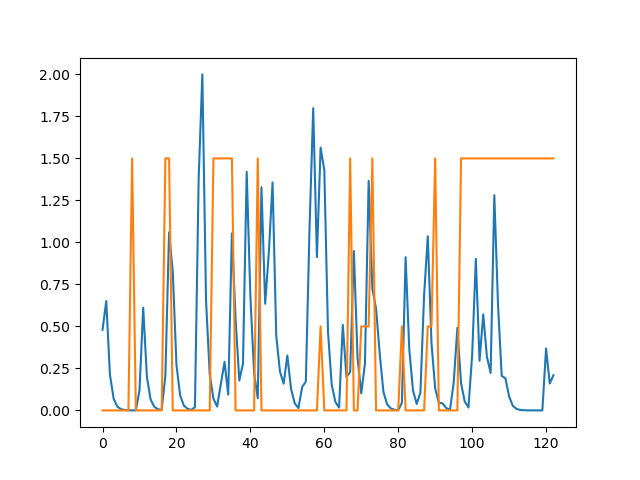

In [354]:
Test2 = C_upd.to_series()
unit = 0
lTest2 = np.array(Test2)[(unit)*rec_dur:(unit+1)*rec_dur]
input_arr = lTest2
R = round(len(lTest2)/(5*list(stamps[0])[2])) # 5 sec bins
split_arr = np.linspace(0, len(input_arr), num=R+1, dtype=int)
dwnsmpl_subarr = np.split(input_arr, split_arr[1:])
dwnsmpl_arrT = np.array( list( np.mean(item) for item in dwnsmpl_subarr[:-1] ) )

SleepScoredTSupd2 = SleepScoredTSupd[:len(dwnsmpl_arrT)]
dwnsmpl_arrT2 = 2*dwnsmpl_arrT/max(dwnsmpl_arrT)
dwnsmpl_arrT2 = dwnsmpl_arrT2[0:len(SleepScoredTSupd)]

plt.close()
plt.plot(dwnsmpl_arrT2)
plt.plot(SleepScoredTSupd2)
plt.show()


Distribute Ca2+ intensity to vigilance state

In [355]:
data = {
    'Unit':np.zeros(nb_unit),
    'Wake' : np.zeros(nb_unit),
    'NREM' : np.zeros(nb_unit),
    'N2' : np.zeros(nb_unit),
    'REM' : np.zeros(nb_unit),
}
Activity_state = pd.DataFrame(data, columns=['Unit', 'Wake', 'NREM', 'N2', 'REM'])

C_upd_unit_id = C_upd['unit_id'].values #added by AB

for unit in range(nb_unit): # nb_unit):
    lTest2 = np.array(Test2)[(unit)*rec_dur:(unit+1)*rec_dur]
    input_arr = lTest2
    R = round(len(lTest2)/(5*list(stamps[0])[2])) # 5 sec bins
    split_arr = np.linspace(0, len(input_arr), num=R+1, dtype=int)
    dwnsmpl_subarr = np.split(input_arr, split_arr[1:])
    dwnsmpl_arrT = np.array( list( np.mean(item) for item in dwnsmpl_subarr[:-1] ) )
    dwnsmpl_arrT = dwnsmpl_arrT[0:len(SleepScoredTSupd)]
    Activity_state["Unit"][unit] = C_upd_unit_id[unit] #added by AB
    for time_stamp in range(len(dwnsmpl_arrT2)):
        if(SleepScoredTSupd2[time_stamp] == 1):
            Activity_state["REM"][unit] = Activity_state["REM"][unit] + dwnsmpl_arrT[time_stamp]    
        elif(SleepScoredTSupd2[time_stamp] == 0.5):
            Activity_state["N2"][unit] = Activity_state["N2"][unit] + dwnsmpl_arrT[time_stamp]     
        elif(SleepScoredTSupd2[time_stamp] == 1.5):
            Activity_state["Wake"][unit] = Activity_state["Wake"][unit] + dwnsmpl_arrT[time_stamp]     
        elif(SleepScoredTSupd2[time_stamp] == 0):
            Activity_state["NREM"][unit] = Activity_state["NREM"][unit] + dwnsmpl_arrT[time_stamp]     


Define how much time (5 sec bin) is spent in each vigilance state

In [356]:
data = {
    'Wake' : np.zeros(2),
    'NREM' : np.zeros(2),
    'N2' : np.zeros(2),
    'REM' : np.zeros(2),
}
Activity_state_time = pd.DataFrame(data, columns=['Wake', 'NREM', 'N2', 'REM'])

for time_stamp in range(len(dwnsmpl_arrT)):
    if(SleepScoredTSupd2[time_stamp] == 1):
        Activity_state_time["REM"][0] = Activity_state_time["REM"][0] + 1   
    elif(SleepScoredTSupd2[time_stamp] == 0.5):
        Activity_state_time["N2"][0] = Activity_state_time["N2"][0] + 1
    elif(SleepScoredTSupd2[time_stamp] == 1.5):
        Activity_state_time["Wake"][0] = Activity_state_time["Wake"][0] + 1    
    elif(SleepScoredTSupd2[time_stamp] == 0):
        Activity_state_time["NREM"][0] = Activity_state_time["NREM"][0] + 1     

Activity_state_time["REM"][1] = Activity_state_time["REM"][0]/len(dwnsmpl_arrT)
Activity_state_time["N2"][1] = Activity_state_time["N2"][0]/len(dwnsmpl_arrT)
Activity_state_time["Wake"][1] = Activity_state_time["Wake"][0]/len(dwnsmpl_arrT)
Activity_state_time["NREM"][1] = Activity_state_time["NREM"][0]/len(dwnsmpl_arrT)
Activity_state_time.index = ['absolu', 'percentage']



Normalise

In [357]:
# Double normalisation 1- by total fluorescence per cell 2- by time spent in each state.
Activity_state_n = Activity_state.copy()
row_sums = Activity_state_n.sum(axis=1)
Activity_state_n = Activity_state_n.div(row_sums, axis=0) #Activity_state_n = Activity_state_n / row_sums[:, np.newaxis]
# % of fluorescence power observed relative to what would have been expected if intensity was uniformally distributed
RelativeWeight = round(Activity_state_n / Activity_state_time.loc['percentage'] * 100)
RelativeWeight.apply(np.sum, axis=0)/nb_unit

N2      34.357143
NREM    67.178571
REM      0.000000
Unit     0.000000
Wake    79.607143
dtype: float64

In [358]:
"""filenameUnit = folder_Minis / f'UnitToKeepAB.xlsx'
unitname = pd.read_excel(filenameUnit)
RelativeWeight['Unit'] =  unitname[0]
"""
RelativeWeight["Unit"]=C_upd_unit_id #added by AB


filenameOut = folder_base / f'IntensityNormalisedVigilanceStatesAB.xlsx'
writer = pd.ExcelWriter(filenameOut)
RelativeWeight.to_excel(writer)
writer.close()

Do the same but instead of fluorescence intensity, use active frames

In [359]:
data = {
    'Unit':np.zeros(nb_unit),
    'Wake' : np.zeros(nb_unit),
    'NREM' : np.zeros(nb_unit),
    'N2' : np.zeros(nb_unit),
    'REM' : np.zeros(nb_unit),
}
Activity_state_frame = pd.DataFrame(data, columns=['Unit', 'Wake', 'NREM', 'N2', 'REM'])

for unit in range(nb_unit):
    lTest2 = np.array(Test2)[(unit)*rec_dur:(unit+1)*rec_dur]
    input_arr = lTest2
    R = round(len(lTest2)/(5*list(stamps[0])[2])) # 5 sec bins
    split_arr = np.linspace(0, len(input_arr), num=R+1, dtype=int)
    dwnsmpl_subarr = np.split(input_arr, split_arr[1:])
    dwnsmpl_arrT = np.array( list( np.mean(item) for item in dwnsmpl_subarr[:-1] ) )
    dwnsmpl_arrT = dwnsmpl_arrT[0:len(SleepScoredTSupd)]
    Activity_state_frame["Unit"][unit] = C_upd_unit_id[unit] #added by AB
    for time_stamp in range(len(dwnsmpl_arrT)):
        if((SleepScoredTSupd2[time_stamp] == 1) and (dwnsmpl_arrT[time_stamp] > 0)):
            Activity_state_frame["REM"][unit] = Activity_state_frame["REM"][unit] + 1    
        elif((SleepScoredTSupd2[time_stamp] == 0.5) and (dwnsmpl_arrT[time_stamp] > 0)):
            Activity_state_frame["N2"][unit] = Activity_state_frame["N2"][unit] + 1    
        elif((SleepScoredTSupd2[time_stamp] == 1.5) and (dwnsmpl_arrT[time_stamp] > 0)):
            Activity_state_frame["Wake"][unit] = Activity_state_frame["Wake"][unit] + 1     
        elif((SleepScoredTSupd2[time_stamp] == 0) and (dwnsmpl_arrT[time_stamp] > 0)):
            Activity_state_frame["NREM"][unit] = Activity_state_frame["NREM"][unit] + 1     


In [360]:
# Double normalisation 1- by total fluorescence per cell 2- by time spent in each state.
Activity_state_frame_n = Activity_state_frame.copy()
Activity_state_frame_n.apply(np.sum, axis=1)
row_sums_frame = Activity_state_frame_n.sum(axis=1)
Activity_state_n = Activity_state_n.div(row_sums, axis=0)# Activity_state_frame_n = Activity_state_frame_n / row_sums_frame[:, np.newaxis]
# % of fluorescence power observed relative to what would have been expected if intensity was uniformally distributed
RelativeWeight_frame = round(Activity_state_frame_n / Activity_state_time.loc['percentage'] * 100)
RelativeWeight_frame.apply(np.sum, axis=0)/nb_unit

N2      11044.928571
NREM    10434.535714
REM         0.000000
Unit        0.000000
Wake    10756.821429
dtype: float64

In [361]:
Activity_state_frame

,Unit,Wake,NREM,N2,REM
0,0.0,39.0,77.0,7.0,0.0
1,1.0,27.0,50.0,7.0,0.0
2,3.0,33.0,53.0,6.0,0.0
3,4.0,39.0,77.0,7.0,0.0
4,5.0,35.0,60.0,7.0,0.0
5,6.0,31.0,75.0,7.0,0.0
6,7.0,32.0,71.0,7.0,0.0
7,8.0,37.0,70.0,7.0,0.0
8,9.0,34.0,74.0,7.0,0.0
9,10.0,39.0,77.0,7.0,0.0


In [362]:
filenameOut = folder_base / f'NumFrameNormalisedVigilanceStatesAB.xlsx'
writer = pd.ExcelWriter(filenameOut)
RelativeWeight_frame.to_excel(writer)
writer.close()


In [363]:
Activity_state_time

,Wake,NREM,N2,REM
absolu,39.000000,77.000000,7.000000,0.0
percentage,0.317073,0.626016,0.056911,0.0
